# **Ghfra Jabour - Mohammad Nour Alawad**


> IR Project - Document Search Engine



# Document Search Engine 

In [ ]:
import pandas as pd
import numpy as np
import os 
import re
import operator
import pickle
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
news = pd.read_json('https://raw.githubusercontent.com/zayedrais/DocumentSearchEngine/master/data/newsgroups.json')

## Data loading

### Document Subject retrieving form data

In [ ]:
for i,txt in enumerate(news['content']):
    #print(i)
    subject = re.findall('Subject:(.*\n)',txt)
    if (len(subject) !=0):
        news.loc[i,'Subject'] =str(i)+' '+subject[0]
    else:
        news.loc[i,'Subject'] ='NA'

In [ ]:
df_news =news[['Subject','content']]

In [ ]:
df_news.head()

,Subject,content
0,0 WHAT car is this!?\n,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,1 SI Clock Poll - Final Call\n,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,2 PB questions...\n,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,3 Re: Weitek P9000 ?\n,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,4 Re: Shuttle Launch Question\n,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


## Data Cleaning and Pre-processing

In [ ]:
# Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
df_news['content']=[entry.lower() for entry in df_news['content']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
SW=['subject:','organization:','thanks','thank','re:']

In [ ]:
for sw in SW:
    df_news.content=df_news.content.replace(to_replace=sw,value='',regex=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
## data Cleaning for content data of news
df_news.content =df_news.content.replace(to_replace='from:(.*\n)',value='',regex=True) #remove from to email 
df_news.content =df_news.content.replace(to_replace='lines:(.*\n)',value='',regex=True)
df_news.content =df_news.content.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) #remove punctuation except
df_news.content =df_news.content.replace(to_replace='-',value=' ',regex=True)
df_news.content =df_news.content.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.content =df_news.content.replace(to_replace='  ',value='',regex=True)                #remove double white space
df_news.content =df_news.content.apply(lambda x:x.strip())  # Ltrim and Rtrim of whitespace

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
## data cleaning for subject data 
df_news.Subject =df_news.Subject.replace(to_replace='Re:',value='',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.Subject =df_news.Subject.replace(to_replace='  ',value='',regex=True)    #remove double white space
df_news.Subject =df_news.Subject.apply(lambda x:x.strip())

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Checking  and dropempty data rows

In [ ]:
## ## Checking  and drop empty data
for i,sen in enumerate(df_news.content):
    if len(sen.strip()) ==0:
        print(str(i))
        #file_data.text[i] = np.nan
        df_news=df_news.drop(str(i),axis=0).reset_index().drop('index',axis=1)

### Word Tokenization

In [ ]:
# tokenization : In this each entry in the file_data will be broken into set of words
df_news['Word tokenize']= [word_tokenize(entry) for entry in df_news.content]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Word Lemmatization

In [ ]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                #print(tag)
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                #file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [ ]:
df_news.shape 

(11314, 3)

In [ ]:
## This Function took around 13 hours for word Lemmatized and remove the Stop words & single character of word of each 11314 rows.
df_clean = wordLemmatizer(df_news['Word tokenize'][0:10]) 
df_clean.head(10)

,Keyword_final
0,"['car', 'nntp', 'post', 'host', 'university', ..."
1,"['si', 'clock', 'poll', 'final', 'call', 'summ..."
2,"['pb', 'question', 'purdue', 'university', 'en..."
3,"['weitek', 'harris', 'computer', 'system', 'di..."
4,"['shuttle', 'launch', 'question', 'smithsonian..."
5,"['reword', 'second', 'amendment', 'idea', 'vtt..."
6,"['brain', 'tumor', 'treatment', 'reply', 'bmde..."
7,"['ide', 'vs', 'scsi', 'new', 'mexico', 'state'..."
8,"['win', 'icon', 'help', 'please', 'university'..."
9,"['sigma', 'design', 'double', 'article', 'univ..."


In [ ]:
# df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
# df_clean=df_clean.replace(to_replace ="'", value = '', regex = True)
# df_clean=df_clean.replace(to_replace =" ", value = '', regex = True)
# df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)

### Added WordLemmatize words into given dataframe

In [ ]:
## Insert New column in df_news to stored the Clean Keyword
#df_news.insert(loc=3, column='Clean_Keyword', value=df_clean['Keyword_final'].tolist())

In [ ]:
## Already Word lemmatize clean keywords the below path:-

#df_news[['Subject','Clean_Keyword']].to_json("WordLemmatize20NewsGroup.json")
df =pd.read_json('https://raw.githubusercontent.com/zayedrais/DocumentSearchEngine/master/data/WordLemmatize20NewsGroup.json')
df_news['Clean_Keyword'] =df['Clean_Keyword']
df_news.head()

,Subject,content,Word tokenize,Clean_Keyword
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...,"[what, car, is, this, nntp, posting, host, rac...","thing,car,nntp,post,host,university,maryland,c..."
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...,"[si, clock, poll, final, call, summary, final,...","guy,kuo,si,clock,poll,final,call,summary,final..."
2,2 PB questions,pb questions... purdue university engineering ...,"[pb, questions, ..., purdue, university, engin...","thomas,willis,pb,question,purdue,university,en..."
3,3 Weitek P9000,weitek p9000 harris computer systems division ...,"[weitek, p9000, harris, computer, systems, div...","joe,green,weitek,harris,computer,system,divisi..."
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...,"[shuttle, launch, question, smithsonian, astro...","jonathan,mcdowell,shuttle,launch,question,smit..."


In [ ]:
df_news_save= df_news
df_news_save = df_news_save.drop(['Word tokenize','Clean_Keyword'],axis=1)
df_news_save.head(3)

,Subject,content
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...
2,2 PB questions,pb questions... purdue university engineering ...


In [ ]:
df_news_save.to_csv("df_news_index.csv", index=False, header=True)

In [ ]:
#df_news =pd.read_csv("df_news.csv")

In [ ]:
## Sample of clean keywords
df_news.Clean_Keyword[0]

'thing,car,nntp,post,host,university,maryland,college,park,line,wonder,anyone,could,enlighten,car,saw,day,sport,car,look,late,early,call,bricklin,door,really,small,addition,front,bumper,separate,rest,body,know,anyone,tellme,model,name,engine,spec,year,production,car,make,history,whatever,info,funky,look,car,please,mail,il,bring,neighborhood,lerxst'

# 1. Create document search engine with TF-IDF

### TF-IDF by using  TfidfVectorizer from sklearn.feature_extraction.text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

## Create Vocabulary
vocabulary = set()

for doc in df_news.Clean_Keyword:
    vocabulary.update(doc.split(','))

vocabulary = list(vocabulary)
print(vocabulary[60:70])
# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary, dtype=np.float32)

# Fit the TfIdf model
tfidf.fit(df_news.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df_news.Clean_Keyword)


['acne', 'isoniazid', 'lxk', 'wipuq', 'lurk', 'newsome', 'cabammerxorns', 'middlesex', 'dashnag', 'atherton']


In [ ]:
print(tfidf_tran.shape)

(11314, 62840)


### Save Trained TFID Model

In [ ]:
### Save model
with open('/content/drive/MyDrive/In-Re project/DocumentSearchEngine/My Deploy_TFID_model/tfid.pkl','wb') as handle:
    pickle.dump(tfidf_tran, handle)

In [ ]:
### load model
t = pickle.load(open('/content/drive/MyDrive/In-Re project/DocumentSearchEngine/My Deploy_TFID_model/tfid.pkl','rb'))

### Save Vacabulary


In [ ]:
### Save Vacabulary
with open("/content/drive/MyDrive/In-Re project/DocumentSearchEngine/My Deploy_TFID_model/vocabulary_news20group.txt", "w") as file:
    file.write(str(vocabulary))

In [ ]:
### load Vacabulary
with open("/content/drive/MyDrive/In-Re project/DocumentSearchEngine/My Deploy_TFID_model/vocabulary_news20group.txt", "r") as file:
    data2 = eval(file.readline())

In [ ]:
len(data2)

62840

### Create vector for Query/search keywords

In [ ]:
## Create vector for Query/search keywords
def gen_vector_T(tokens):

    Q = np.zeros((len(vocabulary)))
    
    x= tfidf.transform(tokens)
    for token in tokens[0].split(','):
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

### Calculate Cosine Similarity with formula 

In [ ]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim
    

### Calculate Cosine similarity of trained Tfidf to input query

In [ ]:
def cosine_similarity_T(k, query):
    #print("Cosine Similarity")
    preprocessed_query = re.sub("\W+", " ", query).strip()
    print(preprocessed_query)
    tokens = word_tokenize(str(preprocessed_query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
    print("\nQuery:", query)
    #print("")
    print(tokens)
    
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    
    for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))
                    
    out = np.array(d_cosines).argsort()[-k:][::-1]
    #print("")
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    for i,index in enumerate(out):
        a.loc[i,'index'] = str(index)
        a.loc[i,'Subject'] = df_news['Subject'][index]
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

In [ ]:
%time cosine_similarity_T(10,'graduation year')
#df_news['Subject']

graduation year

Query: graduation year
['graduation', 'year']
CPU times: user 3.37 s, sys: 3.96 s, total: 7.33 s
Wall time: 4.5 s


,index,Subject,Score
0,1914,1914 Going permanent no mail,0.275604
1,4326,4326 Computer Engr vs Computer Science,0.147798
2,4366,4366 Computer Engr vs Computer Science,0.115212
3,6696,6696 Subaru Shop manuals for sale,0.110571
4,3127,3127 Mostly non computer items Rochester area,0.101573
5,1651,1651 Defensive Averages 1988 1992 Third Base,0.096594
6,6816,6816 Rumours about 3DO,0.095010
7,9057,9057 This year s biggest and worst opinion,0.087091
8,8920,8920 Honors Degrees Do they mean anything,0.081665
9,17,17 Insurance Rates on Performance Cars SUMMARY,0.081197


In [ ]:
df_news['content'][1914]

'going permanent no mail indiana university well it s that time of year again here at iu graduation. unfortunately this means that i am out of here more than likely for good. i cannot say if i ll be in here under another username or not or even if i ll ever get back in here at all. i am leaving this part of my ministry to another brother john right. so have fun and remember that flaming can be considered slander. joe fisher'

# 2. Document Search Engine with Google Universal Sentence Encoder

In [ ]:
!pip install --upgrade tensorflow-gpu
#Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import re, string
import os 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


### Load Google Universal sentence Encoder(DAN) Pretrained model

In [ ]:
#!mkdir /home/zettadevs/GoogleUSE Model
#! curl -L -o 4.tar.gz "https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed" 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#module_path ="/home/zettadevs/GoogleUSEModel/USE_4"
%time model = hub.load(module_url)
#print ("module %s loaded" % module_url)

#Create function for using modeltraining
def embed(input):
    return model(input)

CPU times: user 14 s, sys: 5.79 s, total: 19.8 s
Wall time: 32.3 s


### Use Case of Google USE

In [ ]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features) #1d to 2d
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Similarity")

In [ ]:
def run_and_plot_U(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 45)

In [ ]:
def SimilarityScore(messages):
    message_embeddings = embed(messages)
    corr = np.inner(message_embeddings,message_embeddings)
    for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
    print(corr)

### Use Case 1:- Word semantic

In [ ]:
WordMessage =['software', 'natural language proessing', 'semantic search', 'Artificial intelegence', 'Information retrieval','Data mining']

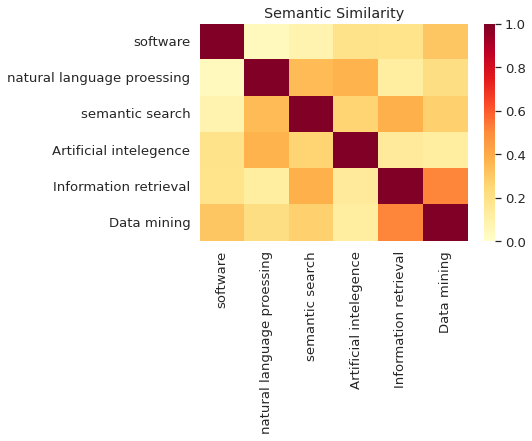

In [ ]:
run_and_plot_U(WordMessage)  # here 'big data' and 'millions od data' it's correlated score is between 0.6 to 0.5.
                            # Even 'AWS' and 'Azure' are also b/w 0.6 to 0.5. As you can see below pic

### Use Case 2: Sentence Semantic

In [ ]:
SentMessage =['my name is ghfran','they call me nour','i\'m called ghfran','do you know nour?']

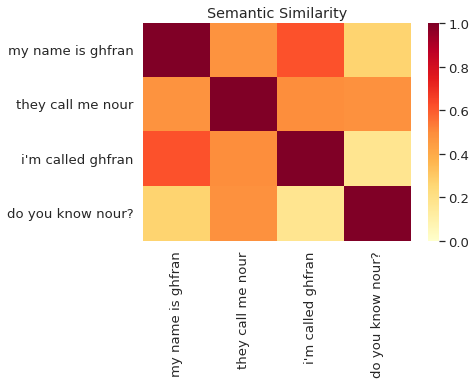

In [ ]:
run_and_plot_U(SentMessage)

### Use Case 3: Word,Sentence and paragram Semantic

In [ ]:
word ='Cloud computing'
Sentence = 'what is cloud computing'
Para =("Cloud computing is the latest generation technology with a high IT infrastructure that provides us a means by which we can use and utilize the applications as utilities via the internet."
        "Cloud computing makes IT infrastructure along with their services available 'on-need' basis." 
        "The cloud technology includes - a development platform, hard disk, computing power, software application, and database.")
Para5 =(
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
Para6 =("Azure is a cloud computing platform which was launched by Microsoft in February 2010."
       "It is an open and flexible cloud platform which helps in development, data storage, service hosting, and service management."
       "The Azure tool hosts web applications over the internet with the help of Microsoft data centers.")
case4Message=[word,Sentence,Para,Para5,Para6]


In [ ]:
SimilarityScore(case4Message)


Message: Cloud computing
Message: what is cloud computing
Message: Cloud computing is the latest generation technology with a high IT infrastructure that provides us a means by which we can use and utilize the applications as utilities via the internet.Cloud computing makes IT infrastructure along with their services available 'on-need' basis.The cloud technology includes - a development platform, hard disk, computing power, software application, and database.
Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Message: Azure is a cloud computing platform which was launched by Microsoft in February 2010.It is an open and flexible cloud platform which helps in development, data storage, service hosting, and service management.The Azure tool hosts web applications over the internet with the help of Microsoft data centers.
[[ 1.          0.7828855   

In [ ]:
len(df_news.content)

11314

## Training the google use model batch wise chunk size 1000 rows

In [ ]:
ls =[]
chunksize =1000
le =len(df_news.content)
for i in range(0,le,chunksize):
    if(i+chunksize > le): 
        chunksize= le;
        ls.append(chunksize)
    else:
        a =i+chunksize
        ls.append(a)
ls
j=0
for i in ls:
    directory = "/content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel/" + str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)
    directory = "/content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel/" + str(i)
    print(j,i) 
    m=embed(df_news.content[j:i])
    #print(df_news.content[j:i],m)
    exported_m = tf.train.Checkpoint(v=tf.Variable(m))
    exported_m.f = tf.function(
      lambda  x: exported_m.v * x,
      input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

    tf.saved_model.save(exported_m,directory)
    j = i
    print(i)

##  Batch wise Load the model

In [ ]:
ar =[]
for i in ls:
    directory = "/content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel/" + str(i)
    if os.path.exists(directory):
        print(directory)
        imported_m = tf.saved_model.load(directory)
        a= imported_m.v.numpy()
        #print(a)
        exec(f'load{i} = a')     

## Concatenate the array from batchwise loaded model

In [ ]:
con_a =np.concatenate((load1000, load2000,load3000,load4000,load5000,load6000,load7000,load8000,load9000,load10000,load11000,load11314))
con_a.shape

(11314, 512)

## Training the model for single time

In [ ]:
## training the model
Model_USE= embed(df_news.content[0:2500])

## Save model for single time

In [ ]:
exported = tf.train.Checkpoint(v=tf.Variable(Model_USE))
exported.f = tf.function(
    lambda  x: exported.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

tf.saved_model.save(exported,'/content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel/assets


## Load model for single time

In [ ]:
## Load Model
imported = tf.saved_model.load('/content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel/')
loadedmodel =imported.v.numpy()
loadedmodel.shape

(2500, 512)

## Create Function to get the top Similare document by giving input as a keyword or sentence.

In [ ]:
def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train =embed(q)
    
    #imported_m = tf.saved_model.load('/content/drive/MyDrive/In-Re project/DocumentSearchEngine/GoogleUSEModel/TrainModel')
    #loadedmodel =imported_m.v.numpy()
    # Calculate the Similarity
    linear_similarities = linear_kernel(Q_Train, con_a).flatten() 
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-11:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'File_Name'] = df_news['Subject'][index] ## Read File name with index from File_data DF
    for j,simScore in enumerate(linear_similarities[:-11:-1]):
        a.loc[j,'Score'] = simScore
    return a


In [ ]:
SearchDocument('graduation year')

,index,File_Name,Score
0,10582,10582 Honors Degrees Do they mean anything,0.219261
1,4032,4032 Players Rushed to Majors,0.218920
2,1914,1914 Going permanent no mail,0.199359
3,9601,9601 Summer Internships,0.195624
4,6067,6067 The Kuebelwagen,0.191727
5,6530,6530 NCAA finals Winner,0.187054
6,5345,5345 Graphics Library Package,0.178184
7,435,435 podiatry School info,0.171815
8,10028,10028 Afterlife,0.164677
9,8571,8571 Mission Aviation Fellowship,0.161734


In [ ]:
df_news.content[10582]

'honors degrees do they mean anything purdue university engineering computer network i hear george bush remember him will receive an honors degree from some kuwaiti university for contributing to certain kuwaiti interests not too long ago. do you think it would add much to his resume'